# Homework 8 - Descriptive Notebook

In this homework notebook, we will create an iterative and targeted gradient attack, to be used on a model trained on the CIFAR10 dataset.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before March 28th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Amarjyot Kaur Narula
# Student ID: 1003084

### Imports needed

In [3]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# Torchvision
from torchvision import datasets, transforms
# Our custom ResNet
from resnet import *

### Testing for CUDA

We advise running on GPU and setting up CUDA on your machine as it might drastically speed up the running time for this notebook!

In [4]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


### Dataset and Dataloader

The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.
The test set has 1000 images in each class, but for simplicity and reduced execution time, we will only use 20 images in each class to evaluate our attack functions.

In [5]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the CIFAR10 dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

In [6]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])

In [7]:
# CIFAR10 dataset and dataloader
# (For testing only, we will use a pre-trained model)
test_dataset = torchvision.datasets.CIFAR10(root = './data/', train = False, transform = tf, download=True)
test_dataset_reduced = torch.utils.data.Subset(test_dataset, [i for i in range(0, 200)])
test_loader = torch.utils.data.DataLoader(dataset = test_dataset_reduced, batch_size = 1, shuffle = False)
print(len(test_loader))


Extracting ./data/cifar-10-python.tar.gz to ./data/
200


### Model

We will use a simple pre-trained resnet model, with architecture and trainer stored in resnet.py and weights stored in file resnet.data.
This is a pre-trained model with a simple architecture. Its baseline accuracy is 88.16%, and a rather easy target for an attack.

In [8]:
# Load the pretrained model
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
pretrained_model = "./resnet.data"
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [9]:
# wrote this cell to test type(image.grad)
for image, label in test_loader:
        
        # Check our original image as loaded from the dataset
        print("1")
        print(image)
        image, label = image.to(device), label.to(device)
        
        # Requiring gradients for the sample does not change the image yet
        # (it just adds an attribute somewhere)
        print("2")
        print(image)
        image.requires_grad = True
        
        # Image has no gradients, it needs to be fed through the model
        # and backpropagation needs to be applied!
        print("3")
        print(image)
        print(type(image.grad))
        
        # Pass image through model and backpropagate for gradients
        print("4")
        output = model(image)
        _, init_pred = torch.max(output.data, 1)
        pred_loss = F.nll_loss(output, label)
        pred_loss.backward(retain_graph = True)
        print(image)
        print(type(image.grad))
        
        # Forced Stop
        assert False, "Forced Stop"

1
tensor([[[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
          [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
          [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
          ...,
          [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
          [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
          [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

         [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
          [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
          [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
          ...,
          [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
          [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
          [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

         [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
          [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
          [0.1843, 0.1294, 0.1412,  ...,

AssertionError: ignored

### Your task

Write a function iugm_attack(), which performs an untargeted iterated gradient attack.
- It should use the Option #2, described in class, which is aiming towards the least probable class, according to the logits.
- It should have a maximal number of iterations, set to 10 by default.
- It has 4 inputs: our original image, the epsilon value to be used, the model under attack, the original label for the image and a maximal number of iterations for the attack.
- Our attack function simply returns the attack sample to be evaluated by our test function.

In [54]:
def iugm_attack(image, epsilon, model, original_label, iter_num = 10):
    
    
    for i in range(iter_num):
        output = model(image)
        _, init_pred = torch.max(output.data, 1)
        _,least_prob_label = torch.min(output.data,1)
        #print("output",output )
        pred_loss = F.nll_loss(output, least_prob_label) #change label to least probabl label
        pred_loss.backward(retain_graph = True)
        #print(image)
        #print(type(image.grad))
        


        #change each pixel of the input image
        data_grad = image.grad.data
        eps_image = image - epsilon*data_grad #should be minus, moving towards the least probable 
        #clip eps_image to maintain pixel values into the [0,1] range
        eps_image = torch.clamp(eps_image,0,1)
        #forward pass
        new_output = model(eps_image)
        #get prediction
        _,new_label = new_output.data.max(1)
        #Check if the new_label different from original label
        if new_label != original_label:
            worked = True
            break
        else:
            image = eps_image
            image.retain_grad()
    
        
    return eps_image



### Testing your attack on your model

Below is our testing function, same as usual.

In [55]:
def test(model, device, test_loader, epsilon, max_iter = 10):

    # Counter for correct values (used for accuracy)
    correct_counter = 0
    
    # List of successful adversarial samples
    adv_examples_list = []

    # Loop over all examples in test set
    for image, label in test_loader:
        
        # Send the data and label to the device
        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor to force torch to
        # keep track of the gradients of the image
        # (Needed for the ugm_attack() function!)
        image.requires_grad = True

        # Pass the image through the model
        output = model(image)
        # Get the index of the max log-probability
        _, init_pred = torch.max(output.data, 1)

        # If the initial prediction is wrong, do not bother attacking, skip current image
        if init_pred.item() != label.item():
            continue
            
        # Call IUGM Attack
        eps_image = iugm_attack(image, epsilon, model, label, max_iter)

        # Re-classify the epsilon image
        output2 = model(eps_image)
        # Get the index of the max log-probability
        _, eps_pred = torch.max(output2.data, 1)

        # Check for successful attack
        # (Successful meaning eps_pred label different from init_pred)
        if eps_pred.item() == label.item():
            correct_counter += 1
            # Special case for saving 0 epsilon examples
            # (Maximal number of saved samples is set to 5)
            if (epsilon == 0) and (len(adv_examples_list) < 5):
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            # (Maximal number of saved samples is set to 5)
            if len(adv_examples_list) < 5:
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon value
    final_acc = correct_counter/float(len(test_loader))
    
    # Display for progress
    print("Epsilon: {} - Model Accuracy (under attack) = {}/{} = {}".format(epsilon, \
                                                                            correct_counter, \
                                                                            len(test_loader), \
                                                                            final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples_list

In [56]:
test(model, device, test_loader, 0.01, max_iter = 1)

Epsilon: 0.01 - Model Accuracy (under attack) = 117/200 = 0.585


(0.585, [(3, 9, array([[[0.6184735 , 0.62338865, 0.6462412 , ..., 0.538589  ,
            0.49446443, 0.45664245],
           [0.5959889 , 0.58879024, 0.6263778 , ..., 0.5383475 ,
            0.4872751 , 0.47137913],
           [0.59016556, 0.5977264 , 0.6188549 , ..., 0.5491573 ,
            0.51484036, 0.4642488 ],
           ...,
           [0.26076457, 0.16135876, 0.12608664, ..., 0.15499769,
            0.04819851, 0.15929285],
           [0.23749521, 0.18353516, 0.14960457, ..., 0.09950815,
            0.11264166, 0.07903569],
           [0.21264693, 0.21574938, 0.18057124, ..., 0.0926972 ,
            0.13677414, 0.0821283 ]],
   
          [[0.439385  , 0.43574962, 0.45745352, ..., 0.3720266 ,
            0.3554652 , 0.3330155 ],
           [0.4380189 , 0.43090793, 0.44670233, ..., 0.36607066,
            0.3509822 , 0.34713668],
           [0.4333998 , 0.436022  , 0.43211085, ..., 0.38009974,
            0.37336624, 0.3446558 ],
           ...,
           [0.4805226 , 0.384615

### Visualization 

As usual, we will display the accuracy vs. epsilon values graph for our given attack, as well as some samples for the given epsilon values.
We will consider two different attack strategies (alpha and beta), with different epsilon values and numbers of maximal iterations 

#### Alpha attack: one-shot untargeted gradient attack

We fix max_iter = 1, which make our iterated attack a one-shot attack.

#### Beta attack: iterated untargeted gradient attack

We fix max_iter = 20.

In [57]:
# Part 1.A
epsilons = [0, .005, .01, .02, .05,  .1, .2, .5, 1]
accuracies = []
examples = []
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, max_iter = 1)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0 - Model Accuracy (under attack) = 176/200 = 0.88
Epsilon: 0.005 - Model Accuracy (under attack) = 144/200 = 0.72
Epsilon: 0.01 - Model Accuracy (under attack) = 117/200 = 0.585
Epsilon: 0.02 - Model Accuracy (under attack) = 89/200 = 0.445
Epsilon: 0.05 - Model Accuracy (under attack) = 62/200 = 0.31
Epsilon: 0.1 - Model Accuracy (under attack) = 28/200 = 0.14
Epsilon: 0.2 - Model Accuracy (under attack) = 21/200 = 0.105
Epsilon: 0.5 - Model Accuracy (under attack) = 17/200 = 0.085
Epsilon: 1 - Model Accuracy (under attack) = 19/200 = 0.095


In [58]:
# Part 1.B
epsilons2 = [0, .001, .002, .005, .01,  .02, .05, .1, .2, .5]
accuracies2 = []
examples2 = []
for eps in epsilons2:
    acc, ex = test(model, device, test_loader, eps, max_iter = 20)
    accuracies2.append(acc)
    examples2.append(ex)

Epsilon: 0 - Model Accuracy (under attack) = 176/200 = 0.88
Epsilon: 0.001 - Model Accuracy (under attack) = 104/200 = 0.52
Epsilon: 0.002 - Model Accuracy (under attack) = 37/200 = 0.185
Epsilon: 0.005 - Model Accuracy (under attack) = 4/200 = 0.02
Epsilon: 0.01 - Model Accuracy (under attack) = 1/200 = 0.005
Epsilon: 0.02 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.05 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.1 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.2 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.5 - Model Accuracy (under attack) = 0/200 = 0.0


The graph below will display the accuracy vs. epsilon value for both attacks (1.A and 1.B).

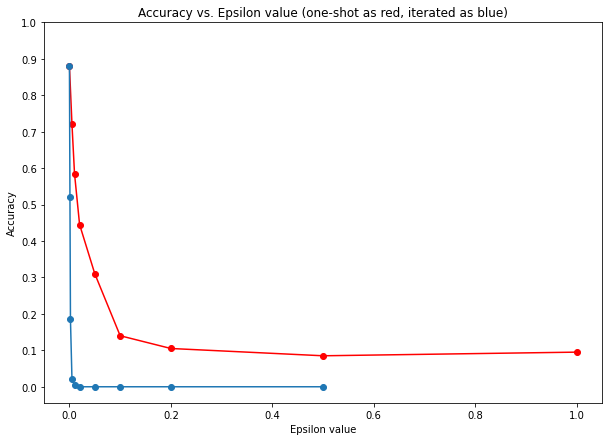

In [59]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-", color = "red")
plt.plot(epsilons2, accuracies2, "o-")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title("Accuracy vs. Epsilon value (one-shot as red, iterated as blue)")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

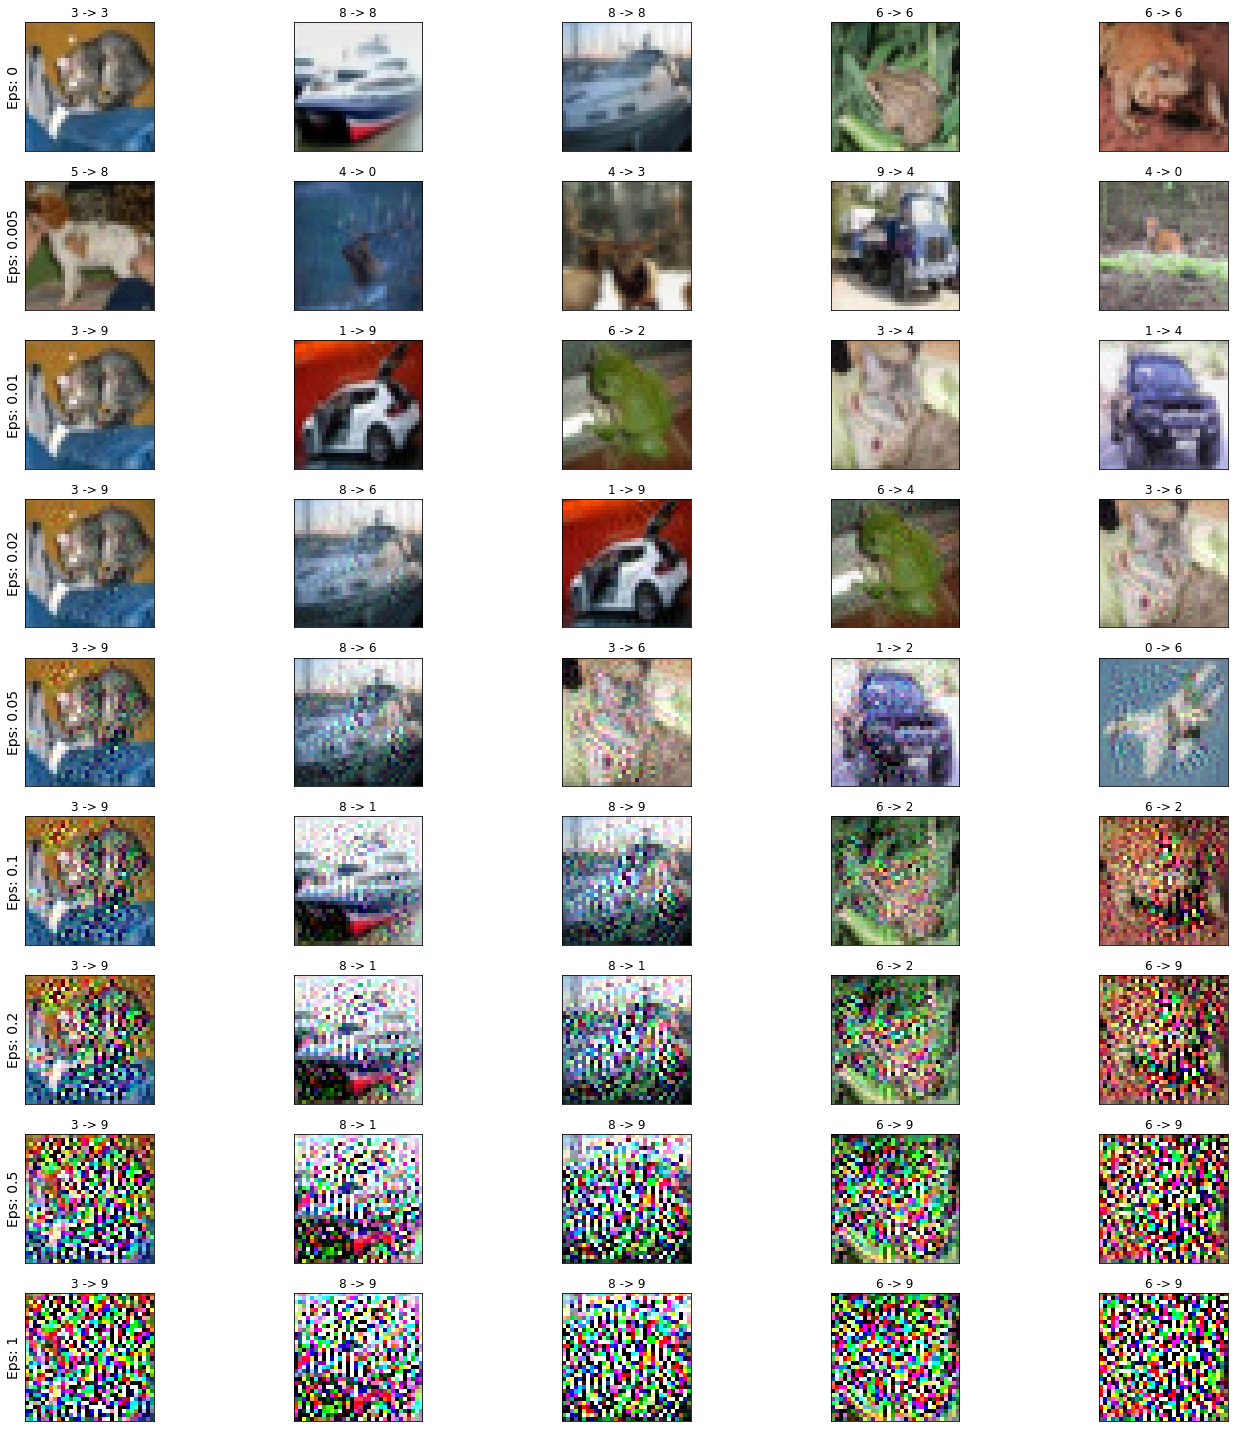

In [60]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (20, 20))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    # If example list does not contain 5 samples for this epsilon,
    # do not display this epsilon value
    if len(examples[i]) != 5:
        continue
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Reshape ex for imshow
        ex = np.transpose(ex, (1, 2, 0))
        
        # Display image
        plt.imshow(ex)
        
# Display full plot
plt.tight_layout()
plt.show()

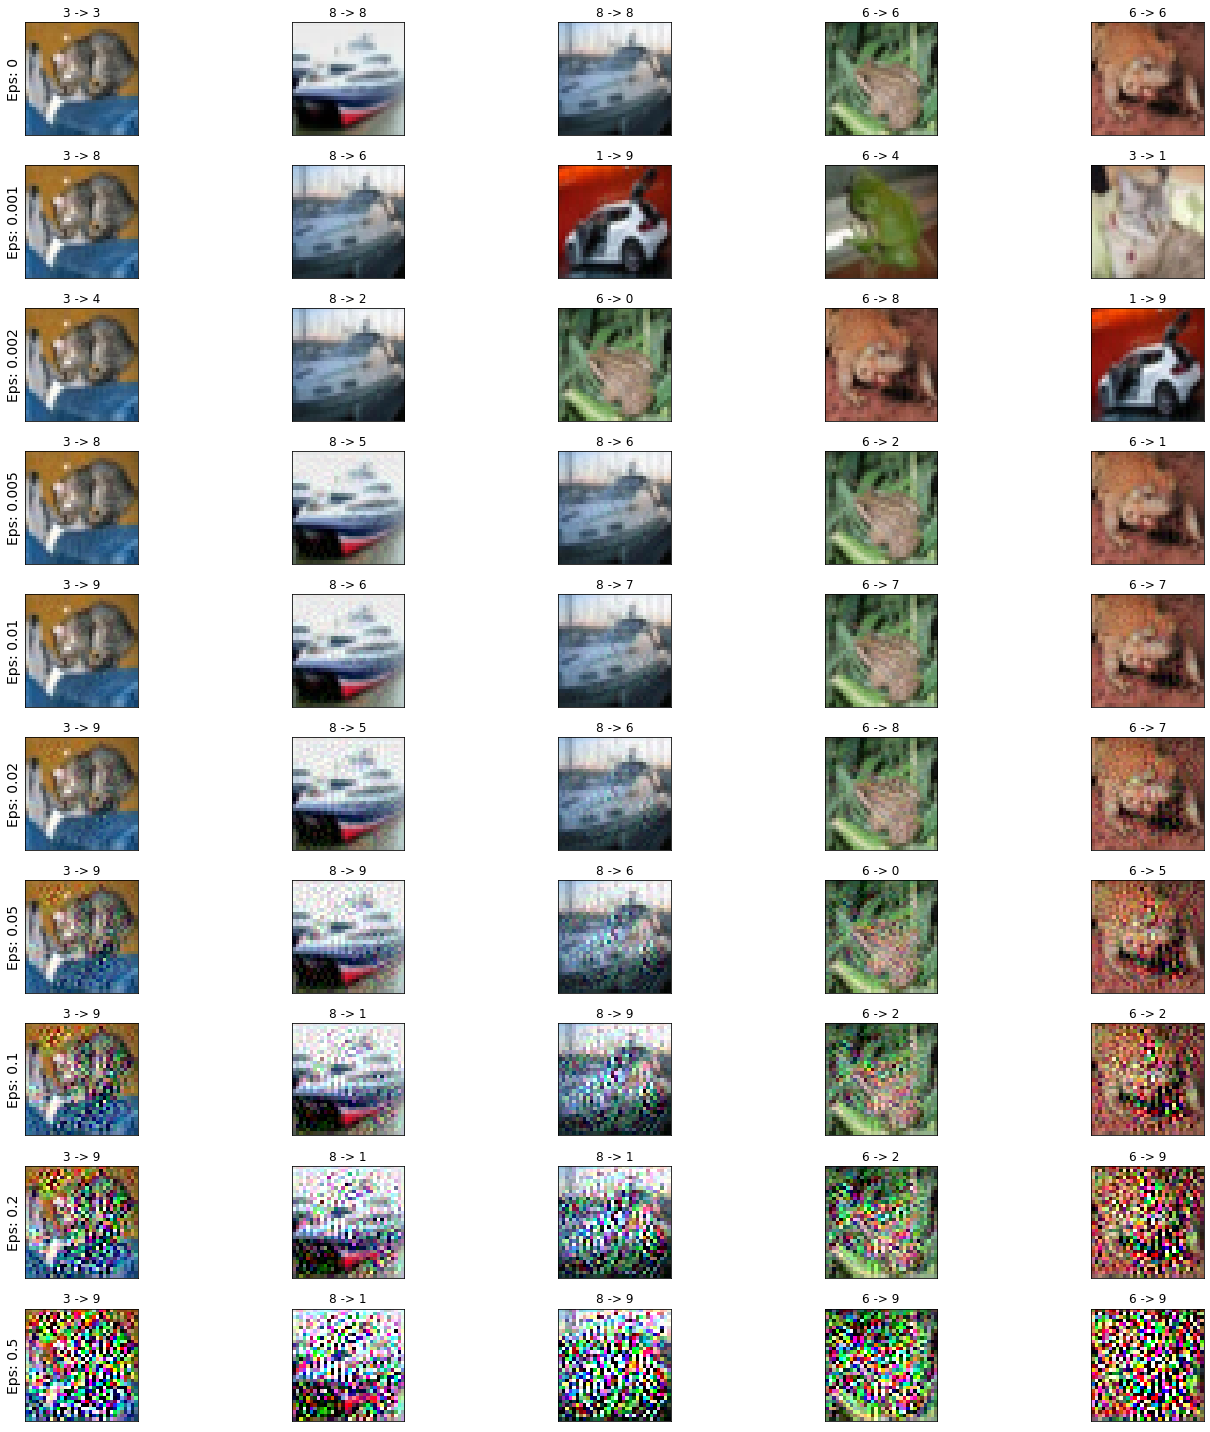

In [61]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (20, 20))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons2)):
    # If example list does not contain 5 samples for this epsilon,
    # do not display this epsilon value
    if len(examples2[i]) != 5:
        continue
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(epsilons2), len(examples2[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons2[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Reshape ex for imshow
        ex = np.transpose(ex, (1, 2, 0))
        
        # Display image
        plt.imshow(ex)
        
# Display full plot
plt.tight_layout()
plt.show()

### Questions and expected answers for the report

A. Copy and paste the code for your iugm_attack() function.

Your answer

B. What do you observe on the accuracy vs. epsilon graph. Why are the two curves different? Is that something to be expected?

C. What seems to be the threshold for plausibility for both attacks (alpha and beta)? Is attack beta a better one? Why?

D. Plausibility seems problematic, even with the iterated version of the gradient attack. Can you suggest two possible ways to improve our attack strategy on this dataset and model?

In [62]:
'''
B: 
Both curves are decreasing exponentially. Blue iterated graph decreases at a faster rate and reaches a lower minimum value, sooner than the red one-shot graph. 
This is expected because iterated gradient attack is better than one-shot as it adjusts the sample iterarively until it makes the model malfunction successfully, making it iteratively more effective and hence, more robust and efficient, than the one-shot method which if it fails, will have to retry on another sample.
Hence, it acheieves a lower accuracy on the model compared to the one-shot attack.
The red graph is the one-shot method while the blue graph is iterated.   (why is it expected or not expected) - expected, compare in terms of accuracy not plausibility, you cannot determine plausibility from the graph

C: 
For alpha, the threshold for plausibility seems to be at epsilon=0.02, where the images still seem to appear as their ground truth label. 
For Beta, the threshold for plausibilty seems to be at epsilon= 0.05
According to the graph, within the threshold range of epsilon = 0.02 to epsilon = 0.5, beta had a lower accuracy than alpha and has a higher plausibility threshold than alpha.
Hence, beta attack appears to perform better than alpha attack.
 

D:
One way to improve this attack strategy is to use the Fast Gradient Sign Method (FGSM) which helps to solve the issue of heavy computational cost and makes more plausible attack samples as it only uses the sign of the gradient to create at attack sample, which 
is alway bounded so there are no big jumps from the original sample. 
Another way to improve plausibility is to use the iterated targetted FGSM attack strategy which repeats the FGSM attack until a maximal number of iterations or until it makes the model malfunction.

'''


'\nB: Both curves are decreasing exponentially. Blue graph decreases at a faster rate and reaches minimum sooner than the red graph. \nThe red graph is the one-shot method while the blue graph is iterated.   (why is it expected or not expected)\n\nC: \nFor alpha, the threshold for plausibility seems to be at epsilon=0.05, where the images still seem to be ______. \nFor Beta, the threshold for plausibilty seems to be at epsilon= 0.05\n\nD:\n \n\n'